# Lesson 06 Assignment - Random Forests

### Problem

Predict the target variable 'pep'

### Instructions

Using the <a href='https://library.startlearninglabs.uw.edu/DATASCI420/2019/Datasets/Bank%20Data.csv'>Bank Data csv</a> file, create a new notebook to train, test, and evaluate an ensemble model. Perform each of the following tasks and answer the related questions:

1. Read in, parse, and pre-process the data
2. Perform a brief exploratory analysis
3. Compare the performance between a decision tree and a random forest approach by assessing the accuracy of each model
4. Graph the structure of your decision tree
5. Graph the confusion matrix of your random forest model

In [1]:
import pandas as pd
import numpy as np

from collections import Counter

from subprocess import check_call

from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

from IPython.display import Image

import matplotlib.pyplot as plt
%matplotlib inline

## Load and prepare data

In [2]:
def load_data(a_url, path, header):
    """Return a DataFrame containing a dataset from url or local path."""
    print('Trying to load the data set from a local file if it exists...')
    try:
        data_set = pd.read_csv(path, header = header)
    except FileNotFoundError:
        print('\tFile not found, loading from Internet...')
        data_set = pd.read_csv(a_url, header = header)
        print('\t\tData loaded from url')
    else:
        print('\tData loaded from local file')
    
    return data_set

In [3]:
url_data = 'https://library.startlearninglabs.uw.edu/DATASCI420/2019/Datasets/Bank%20Data.csv'
local_path_data = './Bank Data.csv'

data = load_data(url_data, local_path_data, 0)

print('Data shape:', data.shape)
print(data.nunique())
print(data.dtypes)
print(data.head())

Trying to load the data set from a local file if it exists...
	Data loaded from local file
Data shape: (600, 11)
age             50
sex              2
region           4
income         599
married          2
children         4
car              2
save_act         2
current_act      2
mortgage         2
pep              2
dtype: int64
age              int64
sex             object
region          object
income         float64
married         object
children         int64
car             object
save_act        object
current_act     object
mortgage        object
pep             object
dtype: object
   age     sex      region   income married  children  car save_act  \
0   48  FEMALE  INNER_CITY  17546.0      NO         1   NO       NO   
1   40    MALE        TOWN  30085.1     YES         3  YES       NO   
2   51  FEMALE  INNER_CITY  16575.4     YES         0  YES      YES   
3   23  FEMALE        TOWN  20375.4     YES         3   NO       NO   
4   57  FEMALE       RURAL  50576.3     YES

In [4]:
# Any missing values?
data.isnull().sum().any()

False

### Apply one-hot encoding to the 'region' variable (with 4 states)

In [5]:
# One hot encode 'region'
region_dummies_df = pd.get_dummies(data['region'], prefix = 'reg')
region_dummies_df.columns.values

array(['reg_INNER_CITY', 'reg_RURAL', 'reg_SUBURBAN', 'reg_TOWN'],
      dtype=object)

In [6]:
# Add one-hot-encoded 'region' to the dataset
data[region_dummies_df.columns.values] = region_dummies_df
data.head()

,age,sex,region,income,married,children,car,save_act,current_act,mortgage,pep,reg_INNER_CITY,reg_RURAL,reg_SUBURBAN,reg_TOWN
0,48,FEMALE,INNER_CITY,17546.0,NO,1,NO,NO,NO,NO,YES,1,0,0,0
1,40,MALE,TOWN,30085.1,YES,3,YES,NO,YES,YES,NO,0,0,0,1
2,51,FEMALE,INNER_CITY,16575.4,YES,0,YES,YES,YES,NO,NO,1,0,0,0
3,23,FEMALE,TOWN,20375.4,YES,3,NO,NO,YES,NO,NO,0,0,0,1
4,57,FEMALE,RURAL,50576.3,YES,0,NO,YES,NO,NO,NO,0,1,0,0


In [7]:
data.columns

Index(['age', 'sex', 'region', 'income', 'married', 'children', 'car',
       'save_act', 'current_act', 'mortgage', 'pep', 'reg_INNER_CITY',
       'reg_RURAL', 'reg_SUBURBAN', 'reg_TOWN'],
      dtype='object')

In [8]:
# Skip the 'region' column and move 'pep' column to the end
data = data[['age', 'sex', 'income', 'married', 'children', 'car', 'save_act',
       'current_act', 'mortgage', 'reg_INNER_CITY', 'reg_RURAL',
       'reg_SUBURBAN', 'reg_TOWN', 'pep']]
data.head()

,age,sex,income,married,children,car,save_act,current_act,mortgage,reg_INNER_CITY,reg_RURAL,reg_SUBURBAN,reg_TOWN,pep
0,48,FEMALE,17546.0,NO,1,NO,NO,NO,NO,1,0,0,0,YES
1,40,MALE,30085.1,YES,3,YES,NO,YES,YES,0,0,0,1,NO
2,51,FEMALE,16575.4,YES,0,YES,YES,YES,NO,1,0,0,0,NO
3,23,FEMALE,20375.4,YES,3,NO,NO,YES,NO,0,0,0,1,NO
4,57,FEMALE,50576.3,YES,0,NO,YES,NO,NO,0,1,0,0,NO


### Apply label encoding to categorical variables (with 2 states only)

In [9]:
# Label encoding solution from
# https://stackoverflow.com/questions/24458645/label-encoding-across-multiple-columns-in-scikit-learn
from collections import defaultdict
# Retain all columns LabelEncoder as dictionary
d = defaultdict(LabelEncoder)
colnames = ['sex', 'married', 'car',
            'save_act', 'current_act', 'mortgage', 'pep']

In [10]:
# Encoding the variables
fit = data[colnames].apply(lambda x: d[x.name].fit_transform(x))

In [11]:
# Check
print(d['sex'].inverse_transform([0, 1]))
print(d['pep'].inverse_transform([0, 1]))

['FEMALE' 'MALE']
['NO' 'YES']


In [12]:
# Using the dictionary to label data
data[colnames] = data[colnames].apply(lambda x: d[x.name].transform(x))
data.head()

,age,sex,income,married,children,car,save_act,current_act,mortgage,reg_INNER_CITY,reg_RURAL,reg_SUBURBAN,reg_TOWN,pep
0,48,0,17546.0,0,1,0,0,0,0,1,0,0,0,1
1,40,1,30085.1,1,3,1,0,1,1,0,0,0,1,0
2,51,0,16575.4,1,0,1,1,1,0,1,0,0,0,0
3,23,0,20375.4,1,3,0,0,1,0,0,0,0,1,0
4,57,0,50576.3,1,0,0,1,0,0,0,1,0,0,0


### Split data into training and testing

In [13]:
# Split data into training and testing sets
feature_names = data.columns[:-1]
X = data[feature_names]
Y = data['pep']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 99)

### The dataset is balanced

Original train dataset shape Counter({0: 260, 1: 220})
Original test dataset shape Counter({0: 66, 1: 54})


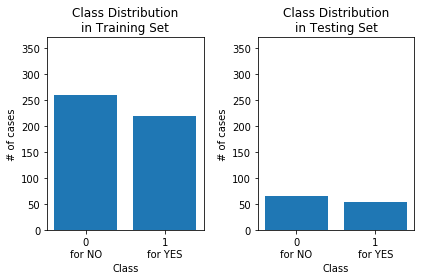

In [14]:
print('Original train dataset shape {}'.format(Counter(y_train)))
print('Original test dataset shape {}'.format(Counter(y_test)))

fig, (ax0, ax1) = plt.subplots(nrows = 1, ncols = 2)

def plot_bar_class(axis, data, title):
    """Plot a sub-plot."""
    axis.bar(Counter(data).keys(), Counter(data).values())
    axis.set_xlabel('Class')
    axis.set_ylabel('# of cases')
    axis.set_ylim(0, 370)
    axis.set_title(title)
    axis.set_xticks([0, 1])
    axis.set_xticklabels(['0\nfor NO', '1\nfor YES'])

plot_bar_class(ax0, Counter(y_train), 'Class Distribution\nin Training Set')
plot_bar_class(ax1, Counter(y_test), 'Class Distribution\nin Testing Set')

plt.tight_layout()
plt.show()

The dataset is balanced in terms the ratio of YES and NO target variables.

### Plot numerical columns to get an overall view

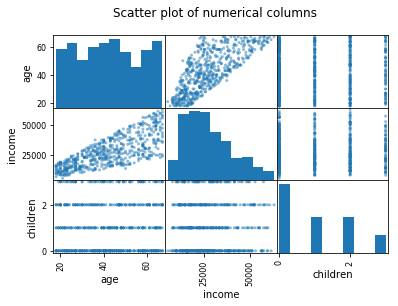

In [15]:
# Plot numerical variables to see if there is any correlation
_ = pd.plotting.scatter_matrix(data[['age', 'income', 'children']])
# plt.title('Scatter plot of numerical columns')
plt.suptitle('Scatter plot of numerical columns')
plt.show()
# plt.tight_layout()

In [16]:
data[['age', 'income', 'children']].corr()

,age,income,children
age,1.000000,0.752726,0.023572
income,0.752726,1.000000,0.036761
children,0.023572,0.036761,1.000000


There is some correlation between income and age but I will ignore it because it does not seem too high.

## Decision Tree and Random Forest

### Search for optimal model parameters -- commenting out the search code because it takes long to run

In [17]:
# Search for optimal model parameters for the decision tree
# from sklearn.model_selection import GridSearchCV
# dt_parameters = {'criterion': ('gini', 'entropy'),
#                  'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
#                  'min_samples_leaf': [4, 5, 6, 7],
#                  'min_samples_split': [2, 3, 4, 5],
#                 }
# dtc = DecisionTreeClassifier()
# gridsearch_dt_clf = GridSearchCV(dtc, dt_parameters, cv=5)  # 'cv=5' for cross validation
# gridsearch_dt_clf.fit(X_train, y_train)
# gridsearch_dt_clf.best_params_

GRID SEARCH OUTPUT FOR DECISION TREE:

{'criterion': 'entropy',<br/>
 'max_depth': 6,<br/>
 'min_samples_leaf': 5,<br/>
 'min_samples_split': 2}

In [18]:
# Search for optimal model parameters for the random forest
# from sklearn.model_selection import GridSearchCV
# rf_parameters = {'n_estimators': [10, 30, 50, 70, 90, 110],
#                  'max_depth': [4, 5, 6, 7, 8, 9, 10, None],
#                  'min_samples_leaf': [1, 3, 4, 5, 6, 7],
#                  'min_samples_split': [2, 3, 4, 5],
#                  'max_features': [2, 3, 4],
#                 }
# rfc = RandomForestClassifier()
# gridsearch_rf_clf = GridSearchCV(rfc, rf_parameters, cv=5)  # 'cv=5' for cross validation
# gridsearch_rf_clf.fit(X_train, y_train)
# gridsearch_rf_clf.best_params_

GRID SEARCH OUTPUT FOR RANDOM FOREST:

{'max_depth': 7,<br/>
 'max_features': 4,<br/>
 'min_samples_leaf': 3,<br/>
 'min_samples_split': 4,<br/>
 'n_estimators': 50}

### Train the models by using the optimal paramerters found by grid search

In [19]:
# Decision tree
np.random.seed(101) # Ensure the decision tree is deterministic
dec_tree = DecisionTreeClassifier(criterion = 'entropy',
                                       max_depth = 6,  # Limit the # of decision levels
                                       min_samples_leaf = 5,  # Limit the # of examples for a leaf
                                       min_samples_split = 2,  # default
                                      ).fit(X_train, y_train)  

# Random forest
min_node_size = 3  # stop splitting if # of observations in the node is 3
rf_clf = RandomForestClassifier(n_estimators = 50,  # Number of trees
                                max_depth = 7,
                                min_samples_split = 4,  # Limit the # of examples for a split
                                max_features = 4,  # Consider x features at each split
                                random_state = 0,
                                verbose = 0,
                                min_samples_leaf = min_node_size,
                               ).fit(X_train, y_train)

### Calculate cross-validation scores -- almost the same

In [20]:
from sklearn.model_selection import cross_val_score
scores_dt = cross_val_score(dec_tree, X_train, y_train, cv = 5)
scores_rf = cross_val_score(rf_clf, X_train, y_train, cv = 5)

In [21]:
print('For cross-validation data:')
print("Decision Tree accuracy: %0.2f (+/- %0.2f)" % (scores_dt.mean(), scores_dt.std() * 2))
print("Random Forest accuracy: %0.2f (+/- %0.2f)" % (scores_rf.mean(), scores_rf.std() * 2))

For cross-validation data:
Decision Tree accuracy: 0.88 (+/- 0.11)
Random Forest accuracy: 0.85 (+/- 0.05)


### Make predictions and evaluate on the testing data -- Decision Tree looks only slightly better

In [22]:
# Make predictions
y_dc_pred = dec_tree.predict(X_test)
y_rf_pred = rf_clf.predict(X_test)

In [23]:
# Generate the accuracy score for the decision tree model on testing data
acc_dec_tree = accuracy_score(y_test, y_dc_pred) * 100
print("Decision tree model's accuracy on testing data is: {:.2f}%".format(acc_dec_tree))

Decision tree model's accuracy on testing data is: 90.00%


In [24]:
# Generate the accuracy score for the random forest model on testing data
acc_random_forest = accuracy_score(y_test, y_rf_pred) * 100
print("Random forest model's accuracy on testing data is: {:.2f}%".format(acc_random_forest))

Random forest model's accuracy on testing data is: 86.67%


### Print confusion matrices for both models -- almost the same

The probability threshold is the default 0.5. I don't see any need to manipulate it to favor any class of outputs because the dataset is almost balanced.

In [25]:
print('Decision tree model confusion matrix')
dec_tree_conf_matrix_obj = confusion_matrix(y_test, y_dc_pred)
conf_matrix_dec_tree = pd.DataFrame(dec_tree_conf_matrix_obj,
                                    columns = ['Predicted NO', 'Predicted YES'],
                                    index = ['True NO', 'True YES']
                                   )
conf_matrix_dec_tree

Decision tree model confusion matrix


,Predicted NO,Predicted YES
True NO,61,5
True YES,7,47


In [26]:
print('Random forest model confusion matrix')
rf_conf_matrix_obj = confusion_matrix(y_test, y_rf_pred)
conf_matrix_rf = pd.DataFrame(rf_conf_matrix_obj,
                              columns = ['Predicted NO', 'Predicted YES'],
                              index = ['True NO', 'True YES']
                             )
conf_matrix_rf

Random forest model confusion matrix


,Predicted NO,Predicted YES
True NO,57,9
True YES,7,47


### Visualize the decision tree

In [27]:
with open("dec_tree.dot", 'w') as dotfile2:
    tree.export_graphviz(dec_tree,
                         out_file = dotfile2,
                         class_names = ['no', 'yes'],  # must be in alphabetical order
                         filled = True,
                         rounded = True,
                         feature_names = feature_names)

# Convert the dot file to a png using subprocess.check_call
check_call(['dot','-Tpng','dec_tree.dot','-o','dec_tree.png'])

0

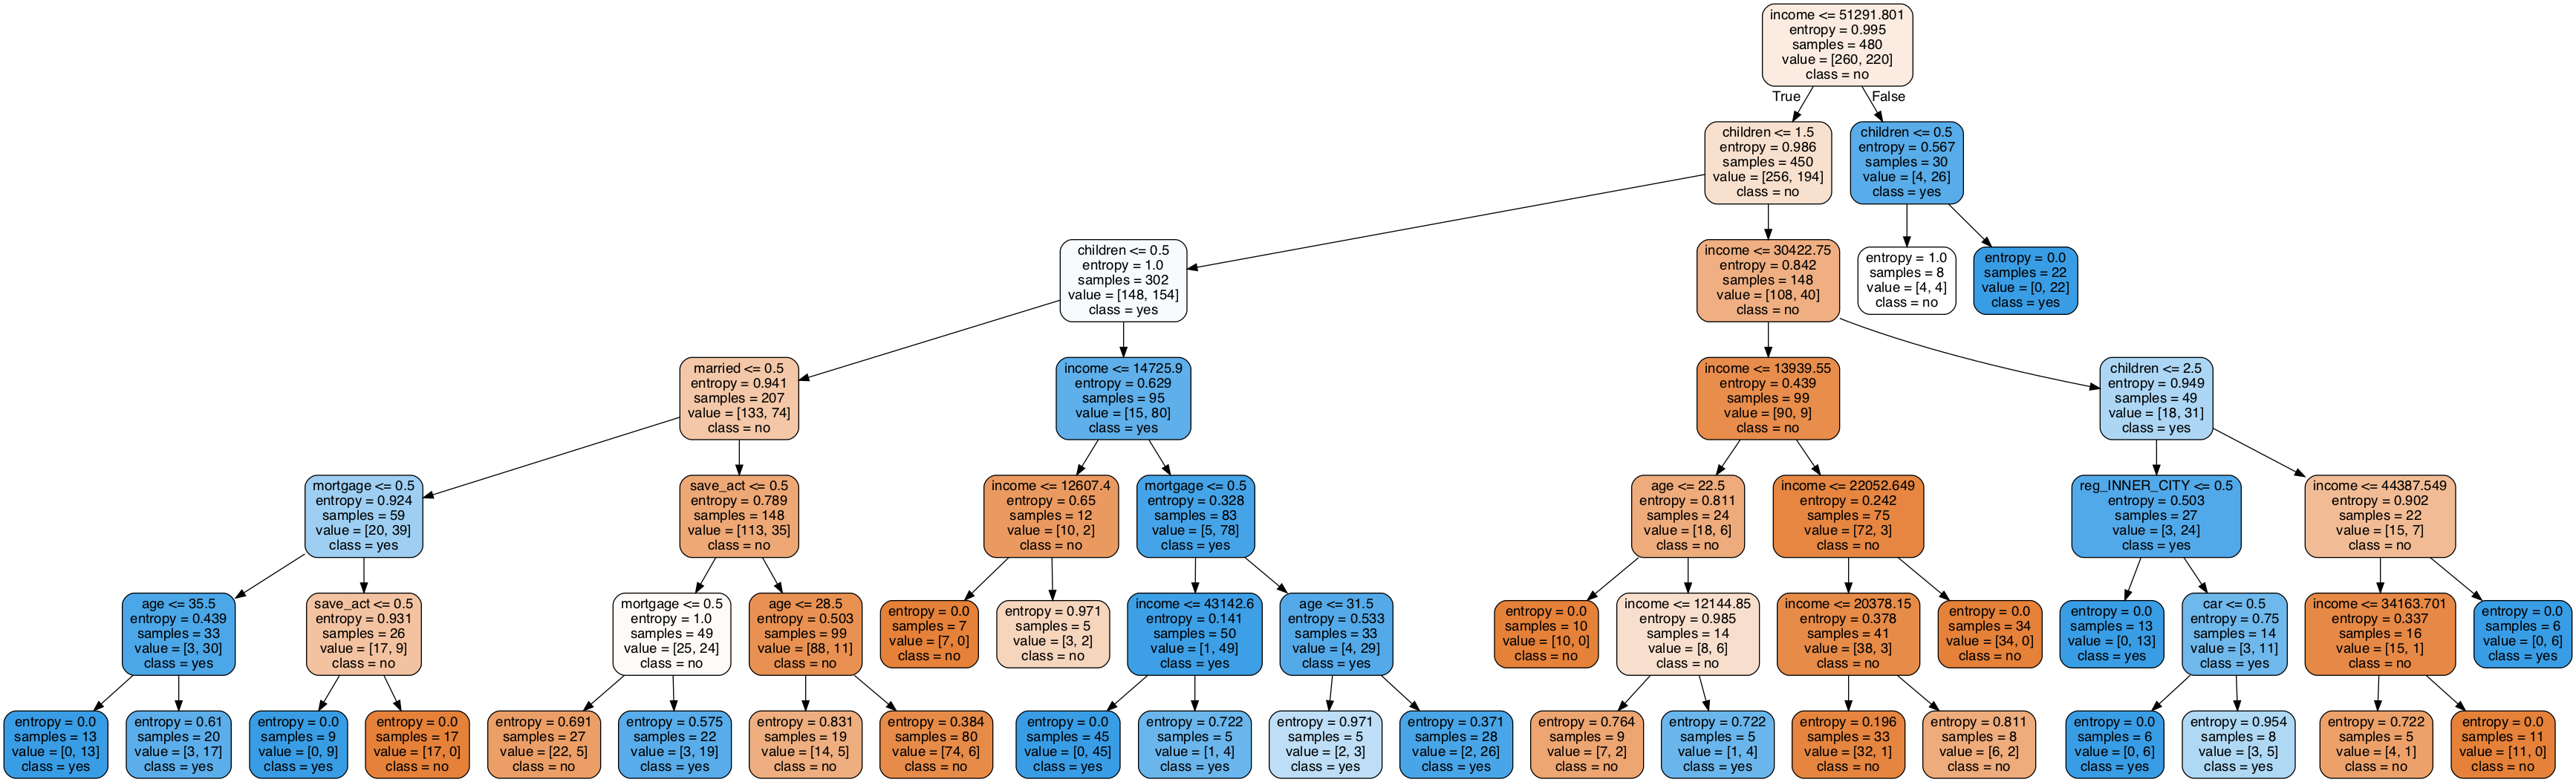

In [28]:
# Use IPython.display.Image
Image(filename = 'dec_tree.png', width = 1000, height = 1000)

In [29]:
# Check the first split, i.e. if 'income' <= 51291, then class 'NO'
data.groupby(['pep'])['income'].mean()  # Is 'income' generally smaller for '0' ('NO') cases?

pep
0    24900.953374
1    30644.919453
Name: income, dtype: float64

### Plot the ROC curve to compare the models -- AUC is almost the same

In [30]:
def do_roc_analysis(XX, YY, model, plot = True):
    """Return area under curve metric and prob. estimates; plot ROC curve."""
    # y = probability estimates of the positive class
    #  [:,1] for predicted probabilities for the positive label only
    y = model.predict_proba(XX.values)[:, 1]
    LW = 1.5  # line width for plots
    LL = "lower right"  # legend location
    LC = "darkgreen"  # Line Color
    # False Positive Rate, True Posisive Rate, probability thresholds
    fpr, tpr, th = metrics.roc_curve(YY.astype(int), y)
    print('First 10 or less prob.thresholds:', np.round(th[:10], 3))
    AUC = metrics.auc(fpr, tpr)
    print('AUC: {:.3f}'.format(AUC))

    if plot:
        plt.figure()
        plt.title('ROC curve, {} Model'.format(type(model)))
        plt.xlim([-0.1, 1.0])
        plt.ylim([-0.1, 1.05])
        plt.xlabel('FALSE Positive Rate')
        plt.ylabel('TRUE Positive Rate')
        plt.plot(fpr, tpr, color=LC, lw=LW,
                 label='ROC curve (area = %0.2f)' % AUC)
        plt.plot(fpr, tpr, 'bo',
                 label='ROC curve (area = %0.2f)' % AUC, alpha = 0.2)
        # reference line for random classifier
        plt.plot([0, 1], [0, 1], color='navy', lw=LW, linestyle='--')
        plt.legend(loc=LL)
        plt.show()

    return AUC, y


ROC curve for the decision tree model
First 10 or less prob.thresholds: [2.    1.    0.929 0.864 0.85  0.8   0.625 0.6   0.5   0.4  ]
AUC: 0.907


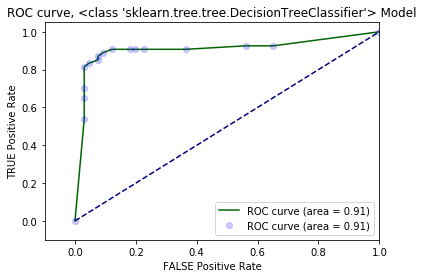

In [31]:
print("\nROC curve for the decision tree model")
_, _ = do_roc_analysis(X_test, y_test, dec_tree)


ROC curve for the random forest model
First 10 or less prob.thresholds: [1.95  0.95  0.754 0.742 0.637 0.636 0.607 0.603 0.552 0.51 ]
AUC: 0.911


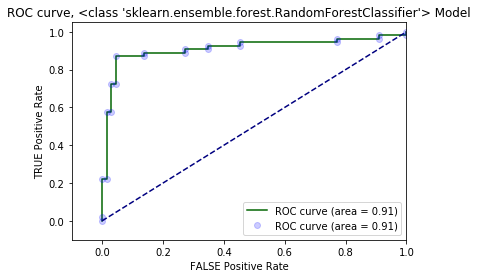

In [32]:
print("\nROC curve for the random forest model")
_, _ = do_roc_analysis(X_test, y_test, rf_clf)

## Summary

The original dataset contains 600 observations and 11 features (including the target), both numerical 
and categorical, with no missing values. 

I applied <b>one-hot encoding</b> to the categorical feature ‘region’ (which had 4 states) and <b>label encoding</b> to all other categorical variables (which only had 2 states each).

Then I split the data into training and testing sets. Because the dataset is balanced, no re-balancing or probability threshold manipulation is required.

By using the <b>grid search</b> method with cross validation, I identified <b>optimal parameters</b> for the decision tree and the random forest classifiers. <b>Average cross validation scores</b> for the Decision Tree and the Random Forest <b>on the training data are 0.88 and 0.85</b>, respectively. I didn't do the model tuning to increase these cross-validation scores because the model parameters were chosen by grid search which as I understand already maximized these scores.

When evaluated <b>on the testing data</b>, the <b>Decision Tree’s accuracy is 0.9</b> and that of the <b>Random Forest is 0.87</b>.  The AUC for both models is about 0.9 and the ROC plots look very similar to each other, indicating that <b>both models perform equally well</b>.